In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import numpy as np 
import pickle
import glob 
import os 
import time , sys
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

from functions import * 

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #
metallicity='mw'
file_ext= '.dat2'



In [2]:
# sort file names so that they are listed by mass, then rotation velocity 
m_val=lambda x : int(x.split('/')[-1].split('.')[0].split('-')[0][1:])
v_val= lambda x : int(x.split('/')[-1].split('.')[0].split('-')[1])

s1=sorted(glob.glob(data_dir +'*'+ file_ext), key=v_val)
data_files=sorted(s1, key= m_val)


#cut stars heavier than 40M, at they do not contribute to Be
data_files=filter(lambda x: m_val(x) < 40, data_files)
#print data_files

mass_list=[]
for f in data_files:
    mass_list=np.append(mass_list, int(m_val(f)))
    
mass_list=np.unique(mass_list)


print 'masses of models :\n',mass_list
print mass_list[0:7]

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35.]
[ 3.  5.  7.  9. 10. 12. 15.]


In [3]:
v_dist=np.poly1d([ 4.96085349e-13, -4.27023037e-10,  6.65435944e-08,  6.46442910e-06
  ,1.93953157e-03])
v_max_val=430

In [4]:
#check that total CDF between mass limits is 1. If not eta0 value needs to be tweaked! 

alpha=2.3
eta0=1 / integrate_imf(3,15, alpha,1)
lower= 3
upper =15

print "integral of IMF between ", lower,'and', upper, ',eta0 = ', eta0, ":"
print integrate_imf(lower , upper , alpha , eta0)

integral of IMF between  3 and 15 ,eta0 =  6.18589967888 :
1.0


STARTING
t = 20.0 : M_max= 10.981980232535436
FINISHED


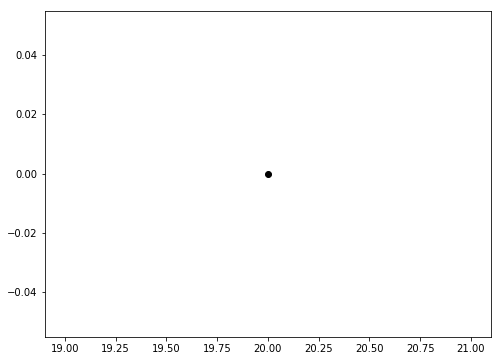

In [8]:
Be_value=0.7 # minimum v/vcrit value required for Be stars 

t_end=50e6 # end time in Myr
n_vals=20
m_vals=mass_list[0:6]

r_df=pd.DataFrame(columns=['t', 'n'])
R_df=pd.DataFrame(columns=['t', 'n'])

start_time = time.time()
print "STARTING"
i=0
i2=0

for t in [20e6]:#np.linspace(0, t_end, n_vals):
    
    resdf1=pd.DataFrame(columns=['f-name','M','t','t_i', 'V', 'T_MS', 'V/Vcrit', 't_i/T_MS'])
   
    
    i=0
    i2=i2+1

    for m in m_vals:
        m_group_files = filter(lambda x : m_val(x)==m, data_files)
        
        for fil in m_group_files:
            f_name=str(m_val(fil)) + '-'+ str(v_val(fil))
            #print message
            message="working on file " +str(i) + " / "+ str(len(data_files)) + " :time loop "+str(i2) + " / "+ str(n_vals)
            #sys.stdout.write ('\r'+ message)
            i=i+1
            
            #load in data and find points on the MS
            df_ms, T_ms= MS_finder2(fil)
            
            
            # index of time closest to t 
            T_indx=(df_ms['1:t[s]']-t).abs().argmin()
            t_i=df_ms['1:t[s]'].loc[T_indx]
            V= df_ms['9:v_surf[km/s]'].loc[T_indx] 
            #if star is rotating 
            if v_val(fil) != 0:
                V_over_Vcrit=V/ df_ms['8:v_crit[km/s]'].loc[T_indx]
                
            else:
                V_over_Vcrit=0
                
            ti_over_tms=t/T_ms
                
            resdf1=resdf1.append(pd.DataFrame([[f_name,m,t,t_i ,V, T_ms,V_over_Vcrit, ti_over_tms]],
                                                  columns=['f-name','M','t','t_i', 'V', 'T_MS', 'V/Vcrit', 't_i/T_MS']))
    
    resdf1.reset_index(drop=True, inplace=True)

    
   

    
    
    R_array=[]
    r_array=[]
    n_inter=2e3 # number of iterations for montecarlo integration 
    

    M_max = M_max_calc(resdf1, v_max_val)
    M_min= resdf1['M'].unique().min() # lowest M value in  result dataframe
    i1= integrate_imf(M_min, M_max, alpha, eta0)    
    
    print "t =", np.round(t/1e6,2) , ': M_max=', M_max
    for u in range (0, int(n_inter)):
        message=str(u) + " / "+ str(int(n_inter)) 
        sys.stdout.write ('\r'+ message)

        rand_m, p_dict, bin_width =random_M_value(resdf1, alpha, eta0)

        V_min =V_min_calc(rand_m, resdf1)
        V_critmin= V_critmin_calc(rand_m, resdf1, Be_value)

        #integral over vdist from v_min(M) to v_max 
        i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)
        
        i3=integrate_vdist(V_critmin,v_max_val,  v_dist,v_max_val)

        #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  np.round(V_min,2), ': M_min=', M_min, 'i2=', np.round(i2,3)
        #pdf= p_dict[rand_m] / bin_width
        R= i1 *i2  #/pdf
        R_array=np.append(R_array, R)
        
        r=i1 * i3
        r_array=np.append(r_array, r)
    
    
    r_df=r_df.append(pd.DataFrame([[t,r_array.mean()]], columns=['t','n']))
    R_df=R_df.append(pd.DataFrame([[t,R_array.mean()]], columns=['t','n']))
        #print '########'
        #print r_array.mean()
    plt.plot(t/1e6, r_array.mean()/R_array.mean(), 'ko')
#resdf1.head(100)
print 'FINISHED'
#print resdf1.to_string()
plt.show()

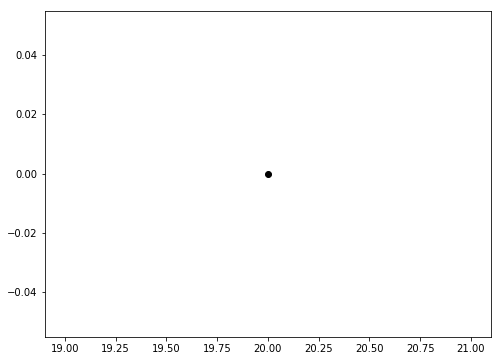

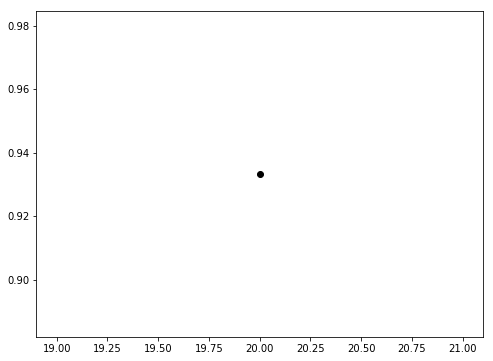

            t        n
0  20000000.0  0.93336
            t    n
0  20000000.0  0.0


In [11]:
plt.plot(r_df.t /1e6, r_df.n, 'ko')
plt.show()

plt.plot(R_df.t /1e6, R_df.n, 'ko')
plt.show()

print R_df
print r_df

In [ ]:
print resdf1.to_string()

In [ ]:
r_array=[]

n_inter=1e3
print eta0, alpha

M_max = M_max_calc(resdf1, v_max_val)
M_min= df['M'].unique().min() # lowest M value in  result dataframe
i1= integrate_imf(M_min, M_max, alpha, eta0)    
print i1, M_min, M_max
s= sample_distribution_shape(resdf1, alpha, eta0)
for u in range (0, int(n_inter)):
    message=str(u) + " / "+ str(int(n_inter)) 
    #sys.stdout.write ('\r'+ message)
 

    #rand_m=random_M_value(resdf1, alpha, eta0)[0]
    
    rand_m, p_dict, bin_width =random_M_value(resdf1, alpha, eta0)
    #print rand_m
    
    V_min =V_min_calc(rand_m, resdf1)

    #integral over vdist from v_min(M) to v_max 
    i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)
    

    #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  np.round(V_min,2), ': M_min=', M_min, 'i2=', np.round(i2,3)
    pdf= p_dict[rand_m] / bin_width
    r= i1 *i2  #/pdf
    r_array=np.append(r_array, r)
    
print '########'
print r_array.mean()



In [ ]:
print resdf1.to_string()

In [ ]:
mass_groups= resdf1.groupby('M')
resdf2=pd.DataFrame(columns=['M','t', 'V_min', 'Tstar_MS', 'V/Vcrit_min'])
for m,mass_group in mass_groups:
    y=df['t_i/T_MS'][(df.M==M)]
    x=mass_group['V']
    
    plt.plot(x,y,'ko')
    plt.title(m)
    plt.show()

In [ ]:


#print resdf1.to_string()

def random_M_value(df, alpha, eta0):
    ##################################
    # PERHAPS WRONG TO FILTER OUT ONLY MS STARS????
    ######################
    M_vals=np.unique(df['M'][df['t_i/T_MS'] <1.0])
    
    #add first mass manually 
    mass_bins=pd.DataFrame([[M_vals[0], M_vals[0],( -M_vals[0]+ M_vals[1])*0.5 + M_vals[0] ]],
                           columns=['M', 'lower_bin', 'upper_bin'])
    
    for i in range(1,len(M_vals)-1):
        l=( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i]
        u= ( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        #print M_vals[i],'lower',( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i],
        #print 'upper',( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        mass_bins=mass_bins.append(pd.DataFrame([[M_vals[i], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
     
    # add last mass manually 
    l=( -M_vals[-2]+ M_vals[-1])*0.5 + M_vals[-2]
    u=  M_vals[-1]
    mass_bins=mass_bins.append(pd.DataFrame([[M_vals[-1], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
    
    #do integration on IMF over bins
    p = lambda x : integrate_imf(x.lower_bin, x.upper_bin, alpha, eta0 )
    mass_bins['p']= mass_bins.apply(p, axis=1)
    
    #print mass_bins
    #print mass_bins['p'].sum()
    p_vals=mass_bins['p']/mass_bins['p'].sum()
    random_m_val= np.random.choice(mass_bins['M'], p=p_vals)# p normalised to sum of probs to avoid sum !=1 error
    
    bin_width= mass_bins['upper_bin'][mass_bins.M == random_m_val]-mass_bins['lower_bin'][mass_bins.M == random_m_val]
    
    
    return random_m_val, dict(zip(M_vals, p_vals)), bin_width.values
    

print random_M_value(resdf1, alpha, eta0)

def M_max_calc(df, v_max_value):
    
    #if non-rotating maximum mass star is still on MS, retun maximum mass star mass
    if df['t_i/T_MS'][(df.M == df['M'].max()) & (df.V == 0)].values[0] < 1.0 :
        return df['M'].max()
    
    
    # x is t/t_ms, y is V
    grid_x, grid_y = np.mgrid[0.5:1:1000j, 0: v_max_value:1000j]
    values = np.array(resdf1['M'].astype(float))
    points=np.array(resdf1[['t_i/T_MS','V' ]])


    grid_z0 = griddata(points, values, (grid_x, grid_y), method='linear')

    #print grid_y[0][950]
    #print grid_x[900][0]

    M_min_candidates=[]
    for x in range(850,1000-1):
        for y in range(850,1000-1):
            M_min_candidates=np.append(M_min_candidates,grid_z0[x][y])

    #plot interpolation
    #plt.imshow(grid_z0, extent=(0.9,1,0.9,1), origin='lower')
    #plt.colorbar()
    #plt.show()
    
    M_min= np.nanmean( M_min_candidates)
    return M_min
print M_max_calc(resdf1, v_max_val)

def V_min_calc(M, df):
    # fractional age of non-rotating model
    non_rot_tovertms= df['t_i/T_MS'][(df.M==M) & (df.V==0)].values
    #print non_rot_tovertms
    #if non rotating model is NOT MS
    if non_rot_tovertms > 1.0:
        # find 2 points eitherside of 1.0 and then linearly interpolate to get V_min 
        y=df['t_i/T_MS'][(df.M==M)]
        x=df['V'][(df.M==M)]
        
        #print df[(df.M==M)]
        #y.reset_index(drop=True, inplace=True)
        #print y[(y-1).abs().argmin()] , x[(y-1).abs().argmin()]
        #print y[(-y+1).argmin()] , x[(-y+1).argmin()]
        
        # get indexes of points with t/Tms straddling t/Tms =1 
        p_1_indx=df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] >1)].argmin()
        m_1_index=df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] <1)].argmax()
        
        #print  y[df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] >1)].argmin()]#(y-1)#.abs()#.argmin()
        #print 'XXXXX'
        #print  y[df['t_i/T_MS'][(df.M==M) & (df['t_i/T_MS'] <1)].argmax()]#(y-1)#.abs()#.argmin()
        
        
        #interpolate between two previously found points to find V at t/Tms=1 
        straight_line=np.poly1d(np.polyfit( [y[p_1_indx], y[m_1_index]],
                                            [x[p_1_indx], x[m_1_index]],
                                            1))
        
       
        #plot to check results 
        #plt.axhline( y[p_1_indx])
        #plt.axhline(y[m_1_index])
        #plt.plot(x,y,'ko')
        #plt.plot(straight_line(1.0), 1, 'go')
        #plt.show()
        
        V_min =straight_line(1.0)
        
        return V_min
    
    
    #if non rotating model is on MS
    else:
        return 0
    
    
#print V_min_calc(12, resdf1)

def sample_distribution_shape(df, alpha, eta0):
    ##################################
    # PERHAPS WRONG TO FILTER OUT ONLY MS STARS????
    ######################
    M_vals=np.unique(df['M'][df['t_i/T_MS'] <1.0])
    
    #add first mass manually 
    mass_bins=pd.DataFrame([[M_vals[0], M_vals[0],( -M_vals[0]+ M_vals[1])*0.5 + M_vals[0] ]],
                           columns=['M', 'lower_bin', 'upper_bin'])
    
    for i in range(1,len(M_vals)-1):
        l=( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i]
        u= ( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        #print M_vals[i],'lower',( -M_vals[i]+ M_vals[i-1])*0.5 + M_vals[i],
        #print 'upper',( -M_vals[i]+ M_vals[i+1])*0.5 + M_vals[i]
        mass_bins=mass_bins.append(pd.DataFrame([[M_vals[i], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
     
    # add last mass manually 
    l=( -M_vals[-2]+ M_vals[-1])*0.5 + M_vals[-2]
    u=  M_vals[-1]
    mass_bins=mass_bins.append(pd.DataFrame([[M_vals[-1], l,u]],columns=['M', 'lower_bin', 'upper_bin'] ))
    
    #do integration on IMF over bins
    p = lambda x : integrate_imf(x.lower_bin, x.upper_bin, alpha, eta0 )
    mass_bins['p']= mass_bins.apply(p, axis=1)
    mass_bins.reset_index(drop=True, inplace=True)
    #print mass_bins
    #print mass_bins['p'].sum()
    p_vals=mass_bins['p']/mass_bins['p'].sum()
    #random_m_val= np.random.choice(mass_bins['M'], p=p_vals)# p normalised to sum of probs to avoid sum !=1 error
    
    #bin_width= mass_bins['upper_bin'][mass_bins.M == random_m_val]-mass_bins['lower_bin'][mass_bins.M == random_m_val]
    
    return dict(zip(M_vals, p_vals)), mass_bins
    #return random_m_val, dict(zip(M_vals, p_vals)), bin_width.values
    
#print sample_distribution_shape(resdf1, alpha, eta0)


def sample_distribution(x):
    if x < M_min or x > M_max:
        return 0  
    p_dict=s[0] 
    
    lower_bins= s[1].lower_bin
    upper_bins= s[1].upper_bin
    
    #print (x-lower_bins).abs().argmin()
    #print (upper_bins -x).abs()
    
    l=lower_bins[(x-lower_bins).abs().argmin()]
    u=upper_bins[ (upper_bins -x).abs().argmin()]
    
    
    
    return p_dict[s[1]['M'].iloc[(x-lower_bins).abs().argmin()]]
    
s= sample_distribution_shape(resdf1, alpha, eta0)


sample_distribution(5.8)

# TESTING #

In [ ]:
print resdf1.to_string()
def V_critmin_calc(M, df, Be_val):
    #select stars still on the MS
    df=df[(df['t_i/T_MS'] <1.0) & (df.M==M) ]
    y=df['V/Vcrit']
    x=df['V']
    
    
    # if there is only one point, cannot do interpolaton, so return infinite value 
    if len(df) ==1 :
        return 1000000
    
    
    #p_indx=df['V/Vcrit'][(df['V/Vcrit'] >Be_val)].argmin()
    #m_index=df['V/Vcrit'][ (df['V/Vcrit'] <Be_val)].argmax()
     
    #interpolate between two previously found points to find V at t/Tms=1 
    #straight_line=np.poly1d(np.polyfit( [y[p_indx], y[m_index]],
                                            #[x[p_indx], x[m_index]],
                                            #1))   
    straight_line=np.poly1d(np.polyfit( y,x,1))
    #plot to check results 
    #plt.axhline( y[p_indx])
    #plt.axhline(y[m_index])
    #plt.plot(x,y,'ko')
    #plt.plot(straight_line(np.linspace(0.5,1,20)),np.linspace(0.5,1,20), 'g-')
    #plt.show()
        
    V_critmin =straight_line(Be_val)
        
    return V_critmin
    
    
    

   

In [ ]:



for o in m_vals:
    print o , V_critmin_calc(o, resdf1, 0.7)
#print V_critmin_calc(12, resdf1, 0.7)

print resdf1.to_string()

In [ ]:
def function(x):
    return np.exp(-x)

r_array=[]

n_inter=3e3
print m_vals, eta0
for u in range (0, int(n_inter)):
    #message=str(u) + " / "+ str(int(n_inter)) 
    #sys.stdout.write ('\r'+ message)

    
    rand_m, p_dict, bin_width =random_M_value(resdf1, alpha, eta0)
    #rand_m =12
    
    #M_max = 12#M_max_calc(resdf1, v_max_val)
    #M_min= 3#df['M'].unique().min() # lowest M value in  result dataframe

    i1=function(rand_m)

    #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  V_min, ': M_min=', M_min
    
    pdf_m= p_dict[rand_m] /bin_width
    
    r= i1  / pdf_m
    r_array=np.append(r_array, r)
    
print '########'
print r_array.mean()


In [ ]:
def function(x):
    return np.exp(-x)

r_array=[]

n_inter=5e6
print m_vals, eta0
for u in range (0, int(n_inter)):
    #message=str(u) + " / "+ str(int(n_inter)) 
    #sys.stdout.write ('\r'+ message)

    
    rand_m= np.random.uniform(3.0,12.0)#, p_dict, bin_width =random_M_value(resdf1, alpha, eta0)
    #rand_m =12
    
    #M_max = 12#M_max_calc(resdf1, v_max_val)
    #M_min= 3#df['M'].unique().min() # lowest M value in  result dataframe

    i1=function(rand_m)

    #print "M value =", rand_m , ': p(M)=',  np.round(p_dict[rand_m], 4), ': V_min=',  V_min, ': M_min=', M_min
    
    #pdf_m= p_dict[rand_m] /bin_width
    
    r= i1  #/ pdf_m
    r_array=np.append(r_array, r)
    
print '########'
print r_array.mean() *(12.0-3.0)

In [ ]:
from skmonaco import mcquad
from skmonaco import mcimport

#    V_min =V_min_calc(rand_m, resdf1)

#    i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)

M_max = M_max_calc(resdf1, v_max_val)
M_min= df['M'].unique().min() # lowest M value in  result dataframe

#    i1= integrate_imf(M_min, M_max, alpha, 1)
def integrand(x):
    V_min =V_min_calc(x, resdf1)
    i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)
    
    M_max=M_max_calc(resdf1, v_max_val)
    i1= integrate_imf(M_min, M_max, alpha, eta0)
    
    return i2 *i2


s=sample_distribution_shape(resdf1, alpha, eta0)
print M_max_calc(resdf1, v_max_val)
result, error = mcimport(f=integrand,
                       distribution= sample_distribution,
     npoints=1e2)
print "{} +/- {}".format(result,error)

In [ ]:
alpha=2.3
eta0=1 / integrate_imf(3,12, alpha,1)
lower= 3
upper =12

print "integral of IMF between ", lower,'and', upper, ',eta0 = ', eta0, ":"
print integrate_imf(lower , upper , alpha , eta0)

In [ ]:
from skmonaco import mcquad
from math import sqrt
result, error = mcquad(
     lambda xs: np.exp(-xs[0]),
     npoints=1e4, xl=[3,0.], xu=[12.,1.])
print "{} +/- {}".format(result,error)

In [ ]:
def integrand(x):
    V_min =V_min_calc(x, resdf1)
    i2=integrate_vdist(V_min,v_max_val,  v_dist,v_max_val)
    
    M_max=M_max_calc(resdf1, v_max_val)
    i1= integrate_imf(M_min, M_max, alpha,eta0)
    #print i1
    return i2 *i2

print 'M_min', M_min, 'M_max', M_max
print 'V_min', V_min

from skmonaco import mcquad
from math import sqrt
result, error = mcquad(
     lambda xs:integrand(xs[0]),
     npoints=1e3, xl=[3, 0.], xu=[12., 1.])
print "{} +/- {}".format(result,error)

print resdf1.to_string()

In [ ]:
print random_M_value(resdf1, alpha, eta0)

df=resdf1
print df['M'].max()
print  df['t_i/T_MS'][(df.M == df['M'].max()) & (df.V == 0)].values
print M_max_calc(resdf1, v_max_val)

In [ ]:
    #print ' '
    #print resdf1.dropna().to_string()
    
    #########################################
    # interpolate values                    #
    #########################################
    #M_max   
    ########################################
    resdf1=resdf1.dropna()
    grid_x, grid_y = np.mgrid[0.5:1:100j, 0.5:1:200j]
    values = np.array(resdf1['M'].astype(float))

    points=np.array(resdf1[['t_i/T_MS','V/Vcrit' ]])

    from scipy.interpolate import griddata
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')

    #plt.imshow(grid_z0, extent=(0.9,1,0.9,1), origin='lower')

    Max_m= 0
    for x in range(0, len(grid_x)):
            for y in range(0, len(grid_y)):
                if grid_z0[x][y] > Max_m:
                    Max_m= grid_z0[x][y]

    #print ' '
    print Max_m , t/1e6

    #v_min
    ##################################################
    
    resdf1=resdf1.dropna()
    x=np.array(resdf1['t_i/T_MS'])#[-20:]
    y=np.array(resdf1['M'])#[-20:]
    z=np.array(resdf1['V'])#[-20:]

    #print x,y,z
    f = interpolate.interp2d(x, y, z, kind='linear')

    m_list=np.linspace(3,12,500)
    for i in m_list:
        plt.plot(i, f(0.9,i), 'k.' )
    
    
    #plt.ylim(-1e5,1e4)
    plt.axhline(0)
    plt.axvline(Max_m)
    plt.title(str(m) +'Msun-'+ str(t/1e6) +'Myr')
    plt.ylabel('V at t=T_ms')
    plt.show()